In [1]:
import os
import numpy as np

# Path to the room's annotation folder
annotation_dir = "Stanford3dDataset_v1.2_Aligned_Version/Area_1/conferenceRoom_1/Annotations"

# Helper to load all point clouds matching a name prefix
def load_objects_by_prefix(folder, prefix):
    objects = []
    for fname in os.listdir(folder):
        if fname.startswith(prefix) and fname.endswith(".txt"):
            path = os.path.join(folder, fname)
            points = np.loadtxt(path)
            objects.append(points)
    return np.vstack(objects) if objects else np.empty((0, 6))

# Load floor and obstacle types
floor = np.loadtxt(os.path.join(annotation_dir, "floor_1.txt"))
walls = load_objects_by_prefix(annotation_dir, "wall_")
chairs = load_objects_by_prefix(annotation_dir, "chair_")

# Combine obstacles into one array
obstacles = np.vstack([walls, chairs])

print("Floor shape:", floor.shape)
print("Walls shape:", walls.shape)
print("Chairs shape:", chairs.shape)
print("Obstacles shape:", obstacles.shape)


Floor shape: (190384, 6)
Walls shape: (354422, 6)
Chairs shape: (77761, 6)
Obstacles shape: (432183, 6)


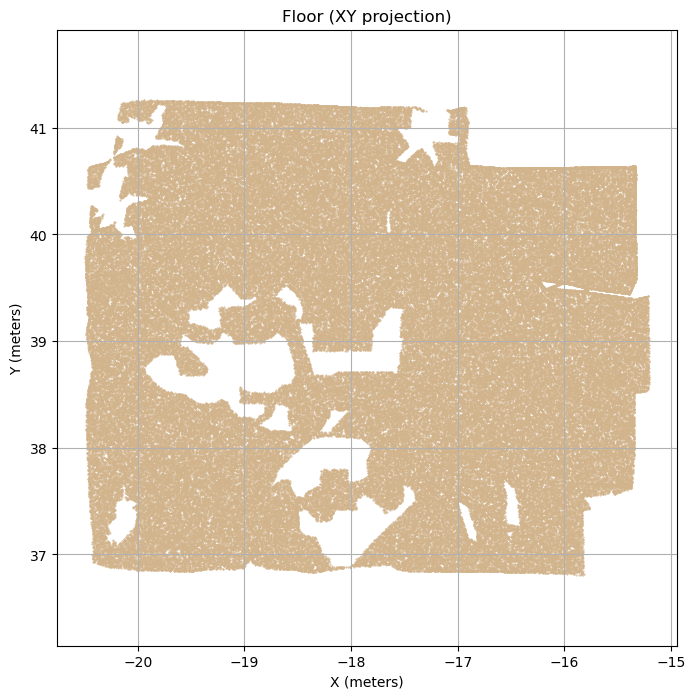

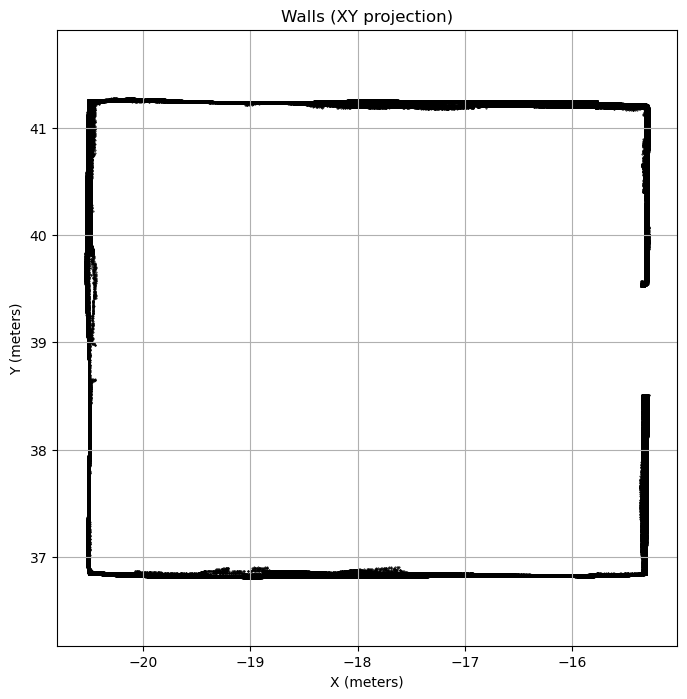

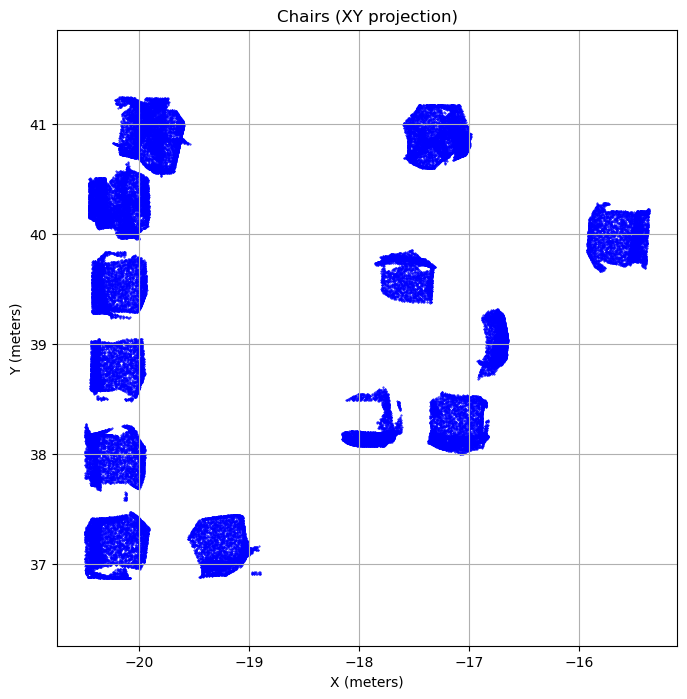

In [2]:
import matplotlib.pyplot as plt

def plot_xy_projection(points, title, color='gray'): 
    plt.figure(figsize=(8, 8)) 
    plt.scatter(points[:, 0], points[:, 1], s=0.2, c=color) 
    plt.title(title) 
    plt.xlabel("X (meters)") 
    plt.ylabel("Y (meters)") 
    plt.axis("equal") 
    plt.grid(True) 
    plt.show()

plot_xy_projection(floor, "Floor (XY projection)", color='tan') 
plot_xy_projection(walls, "Walls (XY projection)", color='black') 
plot_xy_projection(chairs, "Chairs (XY projection)", color='blue')

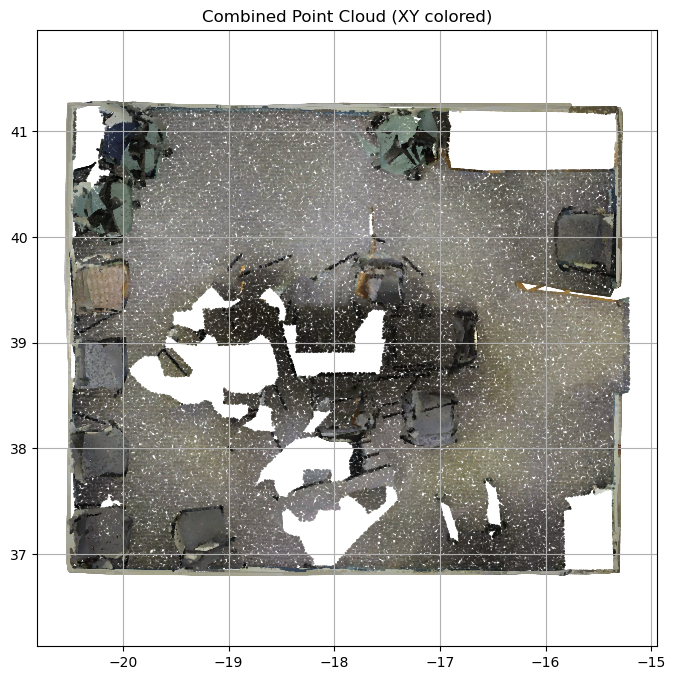

In [3]:
def plot_colored_xy(points, title): 
    colors = points[:, 3:6] / 255.0 # Normalize RGB 
    plt.figure(figsize=(8, 8)) 
    plt.scatter(points[:, 0], points[:, 1], s=0.2, c=colors) 
    plt.title(title) 
    plt.axis("equal") 
    plt.grid(True) 
    plt.show()

combined = np.vstack([floor, walls, chairs]) 
plot_colored_xy(combined, "Combined Point Cloud (XY colored)")

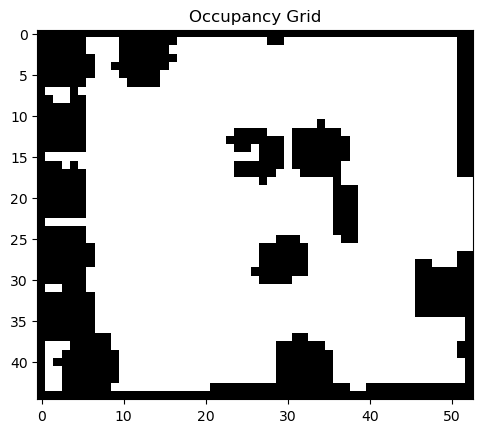

In [4]:
def create_occupancy_grid(points, grid_size=0.1):
    # Project to XY and normalize
    x = points[:, 0]
    y = points[:, 1]
    min_x, max_x = x.min(), x.max()
    min_y, max_y = y.min(), y.max()

    width = int(np.ceil((max_x - min_x) / grid_size))
    height = int(np.ceil((max_y - min_y) / grid_size))

    grid = np.zeros((height, width), dtype=np.uint8)

    # Fill in occupied cells
    for px, py in zip(x, y):
        gx = int((px - min_x) / grid_size)
        gy = int((py - min_y) / grid_size)
        grid[gy, gx] = 1  # Mark as obstacle

    return grid, min_x, min_y

occupancy_grid, offset_x, offset_y = create_occupancy_grid(obstacles)
plt.imshow(occupancy_grid, cmap='gray_r')
plt.title("Occupancy Grid")
plt.show()


In [5]:
from skimage.draw import line

def is_visible(grid, p1, p2):
    rr, cc = line(p1[0], p1[1], p2[0], p2[1])
    for r, c in zip(rr, cc):
        if r < 0 or c < 0 or r >= grid.shape[0] or c >= grid.shape[1]:
            return False
        if grid[r, c] == 1:
            return False
    return True

def compute_visibility_matrix(grid, max_range=50):
    free_cells = np.argwhere(grid == 0)
    visibility = {}

    for idx, src in enumerate(free_cells):
        visible = []
        for dst in free_cells:
            if np.linalg.norm(src - dst) <= max_range and is_visible(grid, tuple(src), tuple(dst)):
                visible.append(tuple(dst))
        visibility[tuple(src)] = visible
        if idx % 100 == 0:
            print(f"Processed {idx}/{len(free_cells)} camera candidates")

    return free_cells, visibility


In [6]:
import cvxpy as cp

def solve_optimization(free_cells, visibility, K):
    num_cells = len(free_cells)
    
    # Index map: cell coordinate -> index
    cell_to_idx = {tuple(cell): i for i, cell in enumerate(free_cells)}

    # Variables
    x = cp.Variable(num_cells, boolean=True)  # camera placement
    y = cp.Variable(num_cells, boolean=True)  # coverage

    # Constraints
    constraints = [cp.sum(x) <= K]

    for j, cell in enumerate(free_cells):
        visible_from = visibility.get(tuple(cell), [])
        if not visible_from:
            constraints.append(y[j] == 0)
            continue
        indices = [cell_to_idx[tuple(src)] for src in visible_from]
        constraints.append(y[j] <= cp.sum(cp.hstack([x[i] for i in indices])))

    # Objective: maximize total coverage
    objective = cp.Maximize(cp.sum(y))
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.GLPK_MI)

    return x.value, y.value, prob.value


In [7]:
# Choose a budget K
K = 10  # Max number of cameras
free_cells, visibility = compute_visibility_matrix(occupancy_grid, max_range=50)
x_val, y_val, coverage_score = solve_optimization(free_cells, visibility, K)
print("Optimal coverage:", coverage_score)


Processed 0/1698 camera candidates
Processed 100/1698 camera candidates
Processed 200/1698 camera candidates
Processed 300/1698 camera candidates
Processed 400/1698 camera candidates
Processed 500/1698 camera candidates
Processed 600/1698 camera candidates
Processed 700/1698 camera candidates
Processed 800/1698 camera candidates
Processed 900/1698 camera candidates
Processed 1000/1698 camera candidates
Processed 1100/1698 camera candidates
Processed 1200/1698 camera candidates
Processed 1300/1698 camera candidates
Processed 1400/1698 camera candidates
Processed 1500/1698 camera candidates
Processed 1600/1698 camera candidates
Optimal coverage: 1698.0


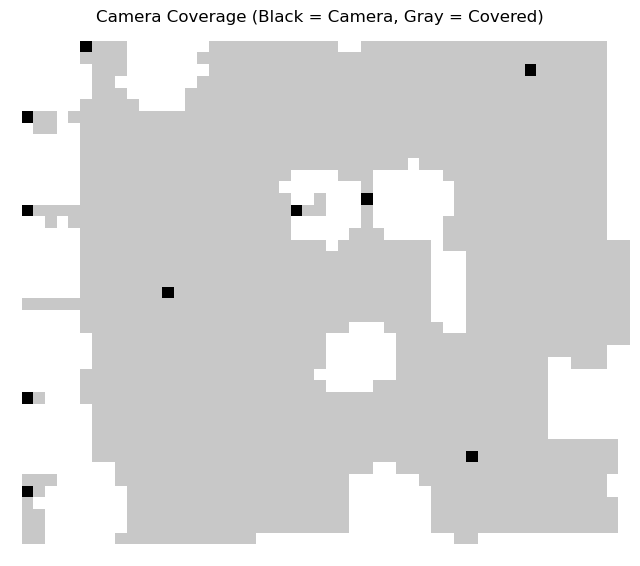

In [8]:
def plot_camera_coverage(grid, free_cells, x_val, y_val):
    placement_indices = [i for i, val in enumerate(x_val) if val > 0.5]
    coverage_indices = [i for i, val in enumerate(y_val) if val > 0.5]

    canvas = np.ones_like(grid, dtype=np.uint8) * 255  # white
    for i in coverage_indices:
        r, c = free_cells[i]
        canvas[r, c] = 200  # light gray
    for i in placement_indices:
        r, c = free_cells[i]
        canvas[r, c] = 0  # black for cameras

    plt.figure(figsize=(8, 8))
    plt.imshow(canvas, cmap='gray')
    plt.title("Camera Coverage (Black = Camera, Gray = Covered)")
    plt.axis('off')
    plt.show()

plot_camera_coverage(occupancy_grid, free_cells, x_val, y_val)
